In [137]:
import numpy as np
from typing import Callable
import vegas
import matplotlib.pyplot as plt
from scipy.optimize import brentq

In [138]:
LOWER_BOUND = -5
UPPER_BOUND = 5

In [139]:
N = 8
a = 1/2
m = 1

In [140]:
T = N*a
A = (m/(2*np.pi*a))**(N/2)

In [141]:
def S_lat(x_lat: np.array, V: Callable):
    S = 0
    for j in range(N):
        S += m/(2*a)*(x_lat[j+1] - x_lat[j])**2 + a*V(x_lat[j])
    return S

In [142]:
def V_ha(x: float):
    return m * x**2 / 2

In [143]:
def integrand_factory(x, V):
    def integrand(x_var):
        x_tot = np.insert(x_var, 0, x)
        x_tot = np.append(x_tot, x)
        return A * np.exp(-S_lat(x_tot, V))
    return integrand

def compute_propagator(x: float, V: Callable, lb=LOWER_BOUND, ub=UPPER_BOUND):
    domain = [[lb, ub]]*(N-1)
    integrator = vegas.Integrator(domain)
    integrator(integrand_factory(x, V), nitn=10, neval=1000)
    result = integrator(integrand_factory(x, V), nitn=20, neval=1000)
    return result

In [144]:
def wavefunction(x: float):
    return np.exp(-x**2 / 2) / np.pi**(1/4)

def predicted_propagator(x: float, E_0: float):
    return wavefunction(x)**2 * np.exp(-E_0*T)

In [145]:
x_exact = np.linspace(0.0, 2.0, 50)
x_PI = np.linspace(0.0, 2.0, 10)

props_exact = predicted_propagator(x_exact, 1/2)
props_PI = []
for x in x_PI:
    prop = compute_propagator(x, V_ha)
    props_PI.append(prop)
props_PI_means = np.array([ p.mean for p in props_PI ])

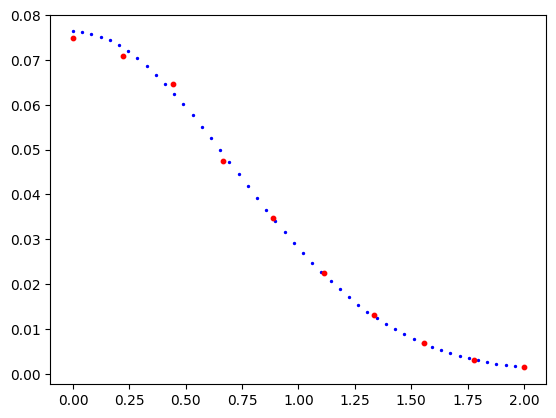

In [146]:
plt.scatter(x_exact, props_exact, s=2, color='blue')
plt.scatter(x_PI, props_PI_means, s=10, color='red')
plt.show()

In [147]:
for i in range(len(props_PI)):
    print(props_PI[i].summary())
    print()
    print()
    print()

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.0661(59)      0.0661(59)          0.00     1.00
  2   0.0698(65)      0.0678(44)          0.17     0.68
  3   0.0798(79)      0.0706(38)          0.98     0.38
  4   0.083(15)       0.0713(37)          0.86     0.46
  5   0.0756(62)      0.0724(32)          0.73     0.57
  6   0.0924(89)      0.0747(30)          1.47     0.20
  7   0.0737(57)      0.0745(27)          1.23     0.29
  8   0.0706(46)      0.0735(23)          1.13     0.34
  9   0.0835(65)      0.0746(22)          1.25     0.27
 10   0.0735(49)      0.0744(20)          1.12     0.35
 11   0.0816(47)      0.0755(18)          1.20     0.28
 12   0.0727(52)      0.0752(17)          1.12     0.34
 13   0.0693(39)      0.0742(16)          1.18     0.29
 14   0.0757(45)      0.0744(15)          1.10     0.36
 15   0.0692(43)      0.0738(14)          1.11     0.34
 16   0.087(12)       0.0740(14)          1.11  

TODO:
- Refactor (generalize code)
- Output the goodness of the integration procedures
- Compare quantitatively Monte Carlo vs exact
- Prove that A is good also for x^4 / 2

# Potential $x^4/2$

In [148]:
from scipy.optimize import brentq

In [149]:
def V_4(x: float):
    return x ** 4 / 2

Compute using PI Monte Carlo

In [150]:
results = []
for x in x_PI:
    result = compute_propagator(x, V_4)
    results.append(result)
    print(result.mean)
means = np.array([ r.mean for r in results ])

0.07731111551166898
0.0730085251834493
0.0642857038718423
0.048782497328759174
0.030824683238981212
0.016598153869588805
0.0065176515699972605
0.0017599892698840884
0.00028551109820392135
2.6469097682321487e-05


In [151]:
print(results[0].summary())

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.0818(75)      0.0818(75)          0.00     1.00
  2   0.0728(97)      0.0784(60)          0.54     0.46
  3   0.0930(94)      0.0826(50)          1.12     0.33
  4   0.0804(55)      0.0816(37)          0.78     0.51
  5   0.0756(46)      0.0793(29)          0.84     0.50
  6   0.0719(40)      0.0768(24)          1.11     0.35
  7   0.0762(51)      0.0767(21)          0.93     0.47
  8   0.0716(44)      0.0757(19)          0.95     0.47
  9   0.0804(59)      0.0761(18)          0.90     0.51
 10   0.090(11)       0.0765(18)          0.96     0.47
 11   0.0863(90)      0.0769(18)          0.98     0.46
 12   0.0858(63)      0.0775(17)          1.06     0.39
 13   0.0753(43)      0.0772(16)          0.99     0.46
 14   0.0784(47)      0.0773(15)          0.92     0.53
 15   0.0723(45)      0.0769(14)          0.93     0.52
 16   0.0837(46)      0.0775(14)          1.01  

Compute using Schrodinger equation solution using Numerov

In [152]:
# Parameters
x_min = LOWER_BOUND
x_max = UPPER_BOUND
N = 1000
dx = (x_max - x_min) / N
X = np.linspace(x_min, x_max, N)
V = V_4(X)

In [153]:
def numerov(E, dx, x, V):
    psi = np.zeros_like(x)
    psi[0] = 0
    psi[1] = 1e-5  # small initial value
    
    k2 = 2 * (E - V)
    
    for i in range(1, len(x) - 1):
        psi[i + 1] = (2 * psi[i] * (1 - 5 * dx**2 * k2[i] / 12) - psi[i - 1] * (1 + dx**2 * k2[i - 1] / 12)) / (1 + dx**2 * k2[i + 1] / 12)
    
    return psi

def find_eigenvalue(E, dx, x, V):
    psi = numerov(E, dx, x, V)
    return psi[-1]

def scan_energy_ranges(V, x, dx, energy_min, energy_max, num_points=100):
    energies = np.linspace(energy_min, energy_max, num_points)
    signs = np.array([np.sign(find_eigenvalue(E, dx, x, V)) for E in energies])
    
    energy_ranges = []
    for i in range(len(signs) - 1):
        if signs[i] != signs[i + 1]:
            energy_ranges.append((energies[i], energies[i + 1]))
    
    return energy_ranges

def get_eigenvalues(V, x, n_eigenvalues, dx, energy_range):
    eigenvalues = []
    for E1, E2 in energy_range:
        E = brentq(find_eigenvalue, E1, E2, args=(dx, x, V))
        eigenvalues.append(E)
    return np.array(eigenvalues)

In [154]:
energy_min = 0
energy_max = 20
num_scan_points = 200

# Find energy ranges that bracket eigenvalues
energy_ranges = scan_energy_ranges(V, X, dx, energy_min, energy_max, num_scan_points)

# Find eigenvalues using the refined energy ranges
eigenvalues = get_eigenvalues(V, X, len(energy_ranges), dx, energy_ranges)

# Calculate the eigenfunctions
eigenfunctions = [numerov(E, dx, X, V) for E in eigenvalues]

# Normalize the eigenfunctions
def normalize(psi, dx):
    return psi / np.sqrt(np.sum(psi[:-70]**2) * dx)

eigenfunctions = [normalize(psi, dx) for psi in eigenfunctions]

In [155]:
def compute_propagator_4(x, E_0):
    index = int((x - LOWER_BOUND) // dx)
    return eigenfunctions[0][index]**2 * np.exp(-E_0*T)

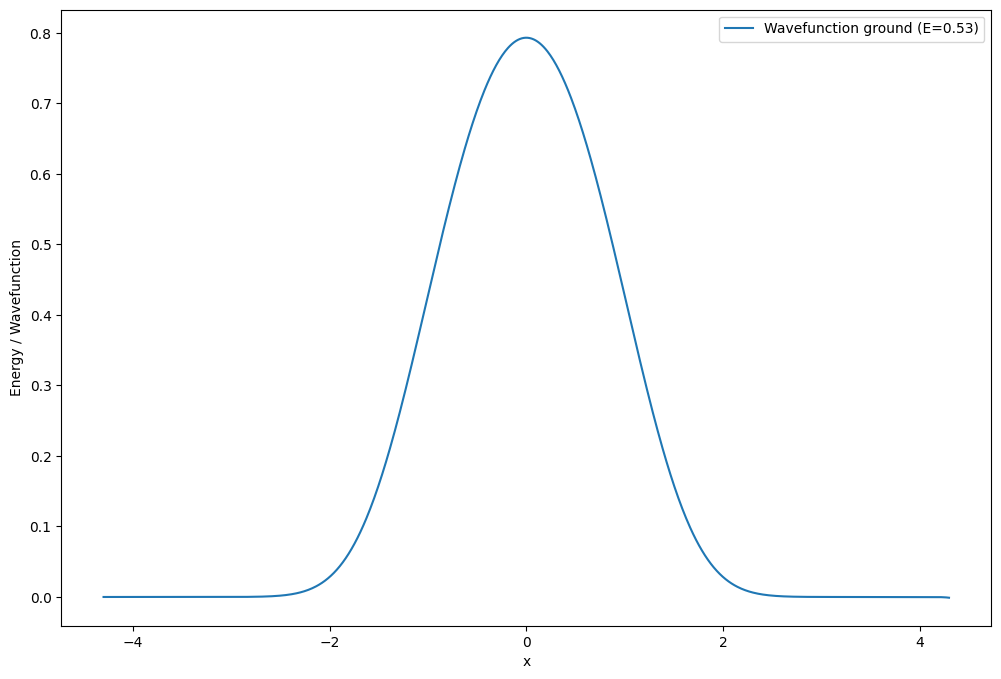

In [156]:
# Plot the potential and the first few eigenfunctions
plt.figure(figsize=(12, 8))
# plt.plot(X, V, label='Potential V(x) = x^4 / 2')

plt.plot(X[70:-70], eigenfunctions[0][70:-70], label=f'Wavefunction ground (E={eigenvalues[0]:.2f})')


plt.xlabel('x')
plt.ylabel('Energy / Wavefunction')
plt.legend()
plt.show()

In [157]:
theoretical_predictions = []
for x in x_exact:
    theoretical_predictions.append(compute_propagator_4(x, eigenvalues[0]))
theoretical_predictions = np.array(theoretical_predictions)

In [158]:
means

array([7.73111155e-02, 7.30085252e-02, 6.42857039e-02, 4.87824973e-02,
       3.08246832e-02, 1.65981539e-02, 6.51765157e-03, 1.75998927e-03,
       2.85511098e-04, 2.64690977e-05])

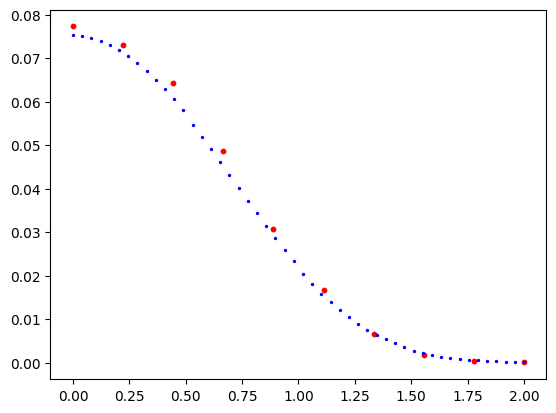

In [159]:
plt.scatter(x_PI, means, s=10, color='red')
plt.scatter(x_exact, theoretical_predictions, s=2, color='blue')
plt.show()

In [160]:
for i in range(len(results)):
    print(results[i].summary())
    print()
    print()
    print()

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.0818(75)      0.0818(75)          0.00     1.00
  2   0.0728(97)      0.0784(60)          0.54     0.46
  3   0.0930(94)      0.0826(50)          1.12     0.33
  4   0.0804(55)      0.0816(37)          0.78     0.51
  5   0.0756(46)      0.0793(29)          0.84     0.50
  6   0.0719(40)      0.0768(24)          1.11     0.35
  7   0.0762(51)      0.0767(21)          0.93     0.47
  8   0.0716(44)      0.0757(19)          0.95     0.47
  9   0.0804(59)      0.0761(18)          0.90     0.51
 10   0.090(11)       0.0765(18)          0.96     0.47
 11   0.0863(90)      0.0769(18)          0.98     0.46
 12   0.0858(63)      0.0775(17)          1.06     0.39
 13   0.0753(43)      0.0772(16)          0.99     0.46
 14   0.0784(47)      0.0773(15)          0.92     0.53
 15   0.0723(45)      0.0769(14)          0.93     0.52
 16   0.0837(46)      0.0775(14)          1.01  